Unfortunately Github doesn't render ipywidgets, which allow us to interactively alter the parameters of the model. If you want to mess with the parameters yourself then download this file, and also install and activate ipywidgets, which you can do in the command line interface with the following commands:
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [1]:
#dependencies
import numpy as np
import operator as op
from functools import reduce
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import cmath
from sympy import *

Parameters:
<br>
$\lambda$ = probability of encountering resources <br>
$S(t)$ = number of solitary locusts at time t [locusts] <br>
$G(t)$ = number of gregarious locusts at time t [locusts] <br>
$R(t)$ = number of resources at time t [mass] <br>
$R^*$ = Value of resources for which consumption rate saturates [mass] <br>
$R_c$ = carrying capacity for resources [mass] <br>
$\alpha$ = percentage of total resources found in a patch, proxy for clumpiness <br>
$k$ = proportion of resources reserved for a solitary locust before gregarious locusts arrive <br>
$h_0$ = foraging rate [mass/time] <br>
$\mu$ = energy cost [mass/time] <br> 
$r$ = resource regeneration rate [1/time] <br>
$p_s, p_g$ = proportion of solitary, gregarious locusts <br>
Note that $G(t)$ and $S(t)$ actually stay the same, but the energy of locusts' changes

<h3>The model:</h3><br>
<h4>Change in energy for gregarious locusts</h4><br>
$$
G(t)\frac{dE_G}{dt} = \left [\sum_{i=0}^{S(t)}{S(t) \choose i}\lambda^i(1-\lambda)^{S(t)-i} i\right ](1-p_sk) \alpha p_sh(R) + G(t)\lambda \alpha p_gh(R) - \mu_GG(t)
$$
Where $h(R)=h_0\frac{R(t)}{(R(t)+R^*)}$ (Instead of $R(t)$ this could be the expected number of resources)
<p>Gregarious locusts gain energy both by discovering resources themselves (second term on the right) and by scrounging off of solitary locusts (first term)</p>


<h4>Change in energy for solitary locusts</h4>
<br>
$$
S(t)\frac{dE_S}{dt} = \left [\sum_{i=0}^{S(t)} {S(t) \choose i} \lambda^i(1-\lambda)^{S(t)-i}i \right ]p_sk \alpha h(R) - \mu_SS(t)
$$

<h4>Change in resources</h4>
$$
\frac{dR}{dt} = -(S(t)(\frac{dE_S}{dt}+\mu_s) + G(t)(\frac{dE_G}{dt}+\mu_G))+rR(t)(1-R(t)/R_c)
$$

In [3]:
##implementation of dimensionalized system - need to update this 
def DE(S, L, R, alpha, k, G, h, us, ug, r, Rn, Rc):
    ps=S/(S+G)
    pg=G/(S+G)
    h = h*R/(R+Rn)
    
    #dE_G/dt
    x=x*h*ps*(1-ps*k)*alpha
    x += glamb*G*alpha*pg*h - ug*G
    
    #dE_S/dt
    y = 0
    for i in range(S):
        y += choose(S,i)*((slamb**i)*((1-slamb)**(S-i))*i)
    y = y*ps*k*alpha*h - us*S
    
    #dR/dt
    z = r*R*(1-(R/Rc)) - S*(y+us) - G*(x+ug)
    return x, y, z

In [4]:
@interact(k=(.05,1,.1), h=(.05, .5, .05), alpha=(0,1,.05), us=(.001,.015, .001), ug=(.001,.015, .001))
def simulate(S=(10,50), L=100, G=(10,50), Rn=30, alpha=.3, k=.35, h=.05, us=.004, ug=.007, r=.2, Rc=100, tsteps=10000):
    dt = .01
    x = np.empty([tsteps + 1,3])
    x[0] = [0,0,Rn]
    for i in range(tsteps):
        g_dot, s_dot, R_dot = DE(S, L, x[i][2], alpha, k, G, h, us, ug, r, Rn, Rc)
        x[i+1][0] = x[i][0]+G*g_dot*dt
        x[i+1][1] = x[i][1]+S*s_dot*dt
        x[i+1][2] = x[i][2]+R_dot*dt
    g = [y[0] for y in x]
    s = [y[1] for y in x]
    r = [y[2] for y in x]
    plt.plot(range(tsteps+1), g, c='b', label='gregarizing locusts\' energy')
    plt.plot(range(tsteps+1), s, c='r', label='solitary locusts\' energy')
    plt.plot(range(tsteps+1), r, c='g', label='resources')
    legend=plt.legend()
    plt.xlabel('time')
    plt.show()

interactive(children=(IntSlider(value=30, description='S', max=50, min=10), IntSlider(value=100, description='…

<h3> Non Dimensionalization </h3>
<br>
We would like to make the system of equations dimensionless so that we can deal with fewer parameters <br>
First note that the sums in the first two DEs evaluate to the expected value of a binomial distribution, which in this case would be $S(t) \lambda$ 
<br>
We set up a time scale $\tau = t/T$ for $T=1/\mu_s$. Thus $\frac{dE_S}{dt}=\frac{dE_S}{d\tau}\frac{d\tau}{dt}=\mu_s\frac{dE_S}{d\tau}$
<br>
Thus our DE for solitary locusts' energy becomes:
$$
\mu_s S(t) \frac{dE_S}{d\tau} = S(t)\lambda p_sk \alpha h(R) - \mu_sS(t) = S(t)\lambda k \alpha h_0 p_s \frac{R(t)}{R(t)+R^*} - \mu_sS(t) 
$$
<br>
Dividing through by $\mu_s S(t)$ yields
$$
\frac{dE_S}{d\tau} = k \gamma p_s \frac{R(t)}{R(t)+R^*} - 1 
$$

where $\gamma = \frac{\alpha h_0 \lambda}{\mu_s}$
<br>
<br>
We also apply this non dimensionalization to gregarious locusts' energy
$$
\mu_sG(t)\frac{dE_G}{d\tau} = S(t)\lambda\alpha p_s h(R) - S(t)\lambda\alpha kp_s^2h(R) + \lambda \alpha p_gh(R)G(t) - \mu_GG(t)
$$
Dividing through yields:
$$
\frac{dE_G}{d\tau} = q(1-kp_s)\gamma p_s\frac{R(t)}{R(t)+R^*} + \gamma p_g \frac{R(t)}{R(t)+R^*} - \mu_l
$$
where $\mu_l = \mu_g/\mu_s$ and $q=S(t)/G(t)$
<br>
<br>
Finally, non dimensionalizing the resource DE yields:
$$
\frac{dR}{d\tau} = r^*R(t)(1-R(t)/R_c) - S(t)(\frac{dE_s}{d\tau}+1) - G(t)(\frac{dE_g}{d\tau}+\mu_l)
$$
where $r^*=r/\mu_s$

In [36]:
def altDE(S, R, k, G, ul, r, Rn, gamma, Rc):
    q = S/G
    ps = S/(S+G)
    pg = G/(S+G)
    h = R/(R+Rn)
    
    
    #dE_G/dtau
    x = q*(1-k*ps)*gamma*ps*h + gamma*pg*h - ul
    
    #dE_S/dt
    y = k*gamma*ps*h - 1
    
    #dR/dt
    z = r*R*(1-(R/Rc)) - S*(y+1) - G*(x+ul)
    return x, y, z


In [38]:
@interact(k=(.05,1.5,.05), S=(0,50,1), G=(0,50,1), ul=(1,3,.1), gamma=(.01,5,.01), Rn=(0,2000,10), Rc=(0,2000), tsteps=(0,100000,100))
def simulate(S=15, G=15, Rn=30, k=.35, ul=1.5, r=.2, gamma=.9, Rc=100, R0=40, tsteps=1000):
    q = S/G
    ps = S/(S+G)
    pg = G/(S+G)
    
    beta = (q**2)*(1-k*ps)*ps + pg
    kappa = (S**2)*k*ps + (G**2)*beta
    coeff = [-r/Rc, r*(1-Rn/Rc), r*Rn-gamma*kappa]
    print(np.roots(coeff))
    gcrit = (1/kappa)*(r*Rn+(Rc*r/4)*(1-Rn/Rc)**2)
    print(gcrit)
    
    dtau = .01
    x = np.empty([tsteps + 1,3])
    x[0] = [0,0,R0]
    for i in range(tsteps):
        g_dot, s_dot, R_dot = altDE(S, x[i][2], k, G, ul, r, Rn, gamma, Rc)
        x[i+1][0] = x[i][0]+G*g_dot*dtau
        x[i+1][1] = x[i][1]+S*s_dot*dtau
        x[i+1][2] = x[i][2]+R_dot*dtau
    g = [y[0] for y in x]
    s = [y[1] for y in x]
    r = [y[2] for y in x]
    plt.plot(range(tsteps+1), g, c='b', label='gregarizing locusts\' energy')
    plt.plot(range(tsteps+1), s, c='r', label='solitary locusts\' energy')
    plt.plot(range(tsteps+1), r, c='g', label='resources')
    legend=plt.legend()
    plt.xlabel('time')
    plt.show()

interactive(children=(IntSlider(value=15, description='S', max=50), IntSlider(value=15, description='G', max=5…

If you change k to the critical value and then change gamma such that the nullclines are positive, you should see that the nullclines are pretty close by.

<h3> Equilibrium for R(t) (Need to Update) </h3>
We set $dR/d\tau=0$ to find an equilibrium
$$
0 = \frac{dR}{d\tau} = r^*R(t)(1-R(t)/R_c) - \frac{R(t)}{R(t)+R^*}(S^2(t)k\gamma p_s +G^2(t)\gamma \beta)
$$
Rearranging yields:
$$
r^*(R(t)+R^*)(1-R(t)/R_c)=\gamma \kappa
$$
Where $\kappa=S^2(t)kp_s + G^2(t)\beta$ <br>
Thus, we get the following solution for $R(t)$ via the quadratic equation:
$$
R(t) = \frac{-r^*(1 - \frac{R^*}{R_c}) \pm \sqrt{(r^*(1-\frac{R^*}{R_c}))^2 + 4(\frac{r^*}{R_c}(r^*R^*-\gamma\kappa))}}{2r^*/R_c}
$$
This has a real solution when the terms in the square root are positive, which requires
$$
\gamma \leq \frac{1}{\kappa}(r^* R^* + \frac{R_c r^*}{4}(1-\frac{R^*}{R_c})^2)
$$
We then conduct a stability analysis of this fixed point by taking the derivate of $dR/d\tau$ relative to $R$:
$$
f'(R) = r^* - \frac{R^*}{(R+R^*)^2}\kappa \gamma
$$


<h3>Adding a genetic component (not being used, see next section)</h3> <br>
Let's say that the population of locusts increases and decreases relative to the locusts' energy. So for the solitary locusts:
$$
\frac{dS}{dt}= E_sgS
$$
where $\left[ g \right]=1/(mass*time)$ and $g << h_0$ (although they don't have the same units), the consumption rate. In Einsteinian fashion, we can equate one locust with a certain amount of energy, such that $S=E_s/C$. Thus we can rearrange the above DE:
$$
\frac{dE_s}{dt} = CE_sgS = E_S^2g
$$
So we can add this component to our original DE for energy:
$$
S(t)\frac{dE_S}{dt} = S(t)\lambda p_sk \alpha h(R) - \mu_SS(t) + CE_sgS^2(t)
$$
Non dimensionalizing yields
$$
\frac{dE_S}{d\tau} = S(t) k \gamma p_s \frac{R(t)}{R(t)+R^*} - 1 + \frac{E_Sg}{\mu_s}S(t)
$$
$$
= \gamma \zeta E_s \frac{R(t)}{R(t)+R^*} - 1 + \rho E_S^2
$$
where $\rho = g/\mu_s$ and $\zeta = kp_s/C$
<br>
<br>
Similarily, for gregarized locusts, adding a genetic component would yield:
$$
\frac{dE_G}{d\tau} = S(t)q(1-kp_s)\gamma p_s\frac{R(t)}{R(t)+R^*} + G(t)\gamma p_g \frac{R(t)}{R(t)+R^*} - \mu_l + \rho E_G^2
$$
Just to clean this up,
$$
\frac{dE_G}{d\tau} = \gamma \omega E_G \frac{R(t)}{R(t)+R^*} - \mu_l + \rho E_G^2
$$
where $\omega = (q^2(1-kp_s)p_s+p_g)/C$
<br>
The change in resources would still only take into account consumption of gregarious and solitary locusts
$$
\frac{dR}{d\tau} = r^*R(t)(1-\frac{R(t)}{R_c}) - \gamma E_G(q\zeta+\omega)\frac{R(t)}{R(t)+R^*}
$$

<h3>Adding an evolutionary component</h3>
The locusts populations grow in proportion to the amount that their energy is greater/less than $\bar{E}$, the energy required to sustain a locust.
$$
\frac{dS}{dt} = \nu S(t)(\frac{E_S}{\bar{E}}-1)
$$
$$
\frac{dG}{dt} = \nu G(t)(\frac{E_G}{\bar{E}}-1)
$$
where $\nu$ is a rate constant.
To non-dimensionalize we divide by $\mu_s$.
$$
\frac{dS}{d\tau} = \nu_* S(t)(\frac{E_S}{\bar{E}}-1)
$$
$$
\frac{dG}{d\tau} = \nu_* G(t)(\frac{E_G}{\bar{E}}-1)
$$
where $\nu^* = \nu/\mu_s << 1$

In [39]:
## python implementation
def genalgDE(S, G, R, Es, Eg, Rn, gamma, k, ul, r, Rc, nu, Ebar):
    q = S/(G+.001)
    ps = S/(G+S)
    pg = G/(G+S)
    beta = (q**2)*(1-k*ps)*ps + pg
    h = R/(R+Rn)
      
    #dE_S/dt
    x = k*gamma*ps*h - 1
    
    #dE_G/dtau
    y = q*(1-k*ps)*gamma*ps*h + gamma*pg*h - ul
    
    #dR/dt
    z = r*R*(1-(R/Rc)) - S*(y+1) - G*(x+ul)
    
    spop = nu*S*((Es/Ebar)-1)
    gpop = nu*G*((Eg/Ebar)-1)
    
    return x, y, z, spop, gpop

In [41]:
@interact(k=(.05,1.5,.05), S0=(0,50,.01), G0=(0,50,.01), R0=(0,1000,10), ul=(1,3,.1), r=(0,.2,.01), gamma=(.01,25,.01), nu=(.0001,.1,.0001), Rn=(0,2000,10), Rc=(0,2000), tsteps=(0,50000,100))
def genalgsim(S0=.01, G0=.01, R0=50, Rn=100, gamma=1.5, k=.35, ul=1.5, r=.02, Rc=200, Ebar = 1, nu = .0036, tsteps=10000):
    
    dtau = .001
    x = np.empty([tsteps + 1,5])
    x[0] = [0,0,R0, S0, G0]
    for i in range(tsteps):
        s, g, z, spop, gpop = genalgDE(x[i][3], x[i][4], x[i][2], x[i][0], x[i][1], Rn, gamma, k, ul, r, Rc, nu, Ebar)
        x[i+1][0] = x[i][0]+s*dtau
        x[i+1][1] = x[i][1]+g*dtau
        x[i+1][2] = x[i][2]+z*dtau
        x[i+1][3] = x[i][3]+spop*dtau
        x[i+1][4] = x[i][4]+gpop*dtau
    
    g = [y[1] for y in x]
    s = [y[0] for y in x]
    res = [y[2] for y in x]
    spop = [y[3] for y in x]
    gpop = [y[4] for y in x]
    
    fig, axs = plt.subplots(2)
    
    #axs[0].plot(range(tsteps+1), g, c='b', label='gregarizing locusts\' energy')
    #axs[0].plot(range(tsteps+1), s, c='r', label='solitary locusts\' energy')
    axs[0].plot(range(tsteps+1), res, c='g', label='resources')
    legend=axs[0].legend()
    axs[1].plot(range(tsteps+1), spop, c='r', label='solitary population')
    axs[1].plot(range(tsteps+1), gpop, c='g', label='gregarious population')
    legend=axs[1].legend()
    plt.xlabel('time')
    print("nu", nu)
    """
    gcrit = []

    for S, G in zip(spop, gpop):
        ps = S/(G+S)
        pg = G/(G+S)
        q=S/G
        beta = (q**2)*(1-k*ps)*ps + pg
        kappa = (S**2)*k*ps + (G**2)*beta
        gcrit.append([(1/kappa)*(r*Rn+(Rc*r/4)*(1-Rn/Rc)**2)])

    #axs[2].plot(range(tsteps+1),gcrit, label='critical gamma')
    #legend=axs[2].legend()
    """
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='S0', max=50.0, step=0.01), FloatSlider(value=0.01, …

<h3>Removing gregarious locusts</h3>
Analysis is very complicated with 5 equations dictating the dynamics of gregarious and solitary locusts. Let's look at the system with only solitary locusts. We thus have the following three equations for locusts' energy, resources, and locusts' population:
$$
\frac{dE_S}{d\tau} = k \gamma p_s \frac{R(t)}{R(t)+R^*} - 1 = k\gamma \frac{R(t)}{R(t)+R^*} - 1
$$
where $p_s=1$
$$
\frac{dR}{d\tau} = r^*R(t)(1-R(t)/R_c) - S(t)(\frac{dE_s}{d\tau}+1)
$$
$$
\frac{dS}{d\tau} = \nu_* S(t)(\frac{E_S}{\bar{E}}-1)
$$
Setting this system equal to the zero vector yields the following fixed points (using Sympy):
$$
\left [ E_S^*(t), S^*(t), R^*(t) \right ] = \left [ \bar{E}, \frac{R^*r^*(R_c\gamma k -R_c - R^*)}{R_c(\gamma k - 1)^2}, \frac{R^*}{\gamma k - 1} \right ]
$$
In order for $S^*(t)>0$, we need $\gamma > \frac{R_c+R^*}{R_ck}$
<br>
Since we find that this fixed point is essentially never stable, it is worth asking when $dR/d\tau>0$ as a function of $S(t)$. Can resources grow when there are locusts. We get the following nulcline:
$$
R(t) = R_c/2 - R^*/2 \pm \sqrt{r^*(-4R_c\gamma kS(t) + R_c^2r^* + 
$$

In [6]:
##python implementation: only solitary locusts
def solDE(S, R, Es, Rn, gamma, k, r, Rc, nu, Ebar):
    h = R/(R+Rn)
    
    x = k*gamma*h - 1
    
    z = r*R*(1-R/Rc) - S*(x+1)
    
    spop = nu*S*((Es/Ebar)-1)
    
    return x, z, spop

In [10]:
@interact(k=(.05,1.5,.05), S0=(0,50,.01), R0=(0,1000,10), r=(0,2,.01), gamma=(.01,25,.01), nu=(.0001,.1,.0001), Ebar=(0,20,.01), Rn=(0,2000,10), Rc=(0,2000), tsteps=(0,1000000,100))
def solsim(S0=0, R0=190, Rn=100, gamma=1.52, k=.35, r=.08, Rc=200, Ebar = 5, E0=5, nu = .0036, tsteps=100000):
    Rc=Rn/(k*gamma - 1)
    
    dtau = .001
    x = np.empty([tsteps + 1,3])
    x[0] = [E0, R0, S0]
    for i in range(tsteps):
        s, z, spop = solDE(x[i][2], x[i][1], x[i][0], Rn, gamma, k, r, Rc, nu, Ebar)
        x[i+1][0] = x[i][0]+s*dtau
        x[i+1][1] = x[i][1]+z*dtau
        x[i+1][2] = x[i][2]+spop*dtau
    
    s = [y[0] for y in x]
    res = [y[1] for y in x]
    spop = [y[2] for y in x]
    
    
    fig, axs = plt.subplots(2)
                   
    axs[0].plot(range(tsteps+1), s, c='r', label='solitary locusts\' energy')
    axs[0].plot(range(tsteps+1), res, c='g', label='resources')
    legend=axs[0].legend()
    axs[1].plot(range(tsteps+1), spop, c='r', label='solitary population')
    legend=axs[1].legend()
    plt.xlabel('time')
    print("nu", nu)
    
    
    Scrit = Rn*r*(Rc*gamma*k-Rc-Rn)/(Rc*(gamma*k-1)**2)
    Rcrit = Rn/(gamma*k-1)
    print("Scrit", Scrit)
    print("Rcrit",Rcrit)
    
    gcrit = (Rc + Rn)/(Rc*k)
    print("gamma for Scrit to be positive", gcrit)
    
    M = Matrix([[0, 0, gamma*k*Rn/(Rcrit+Rn)**2], [nu*Scrit/Ebar, 0, 0], [0, k*gamma*Rcrit/(Rcrit+Rn), r*(1-(Rcrit/Rc))-(r*Rcrit/Rc)-(Scrit*k*gamma*Rn)/(Rcrit+Rn)**2]])
    evals = M.eigenvals()
    print("evals",evals)
    
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='S0', max=50.0, step=0.01), IntSlider(value=190, desc…

In [14]:
##Solving equilibrium
import math
R, S, g, k, n, r, c, b, E, v = symbols('R, S, g, k, n, r, c, b, E, v', real=True)
y = nonlinsolve([v*S*((E/b)-1), (k*g*R/(R+n))-1, r*R*(1-(R/c)) - S*k*g*R/(R+n)], [E, S, R])
#print(y)

Scrit = n*r*(c*g*k-c-n)/(c*(g*k-1)**2)
Rcrit = n/(g*k-1)
c=Rcrit
M = Matrix([[0, 0, g*k*n/(Rcrit+n)**2], [v*Scrit/b, 0, 0], [0, k*g*Rcrit/(Rcrit+n), r*(1-(Rcrit/c))-(r*Rcrit/c)-(Scrit*k*g*n)/(Rcrit+n)**2]])
evals = M.eigenvals()
#print(evals)

##when sol is real
#z = nonlinsolve([c*r*(c*r-4), (c*r)**2 - 4*c*r], [c, r])
ev1 = -(sqrt((2*(-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(b*c*g*k))**2 - 4*(-c*g*k*r + c*r + g*k*n*r + n*r)**6/(c*g**2*k**2 - c*g*k)**6)/2 + (-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(2*b*c*g*k))**(1/3)/3 - (-c*g*k*r + c*r + g*k*n*r + n*r)/(3*(c*g**2*k**2 - c*g*k)) - (-c*g*k*r + c*r + g*k*n*r + n*r)**2/(3*(c*g**2*k**2 - c*g*k)**2*(sqrt((2*(-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(b*c*g*k))**2 - 4*(-c*g*k*r + c*r + g*k*n*r + n*r)**6/(c*g**2*k**2 - c*g*k)**6)/2 + (-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(2*b*c*g*k))**(1/3))
ev2 = -(-1/2 + sqrt(3)*I/2)*(sqrt((2*(-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(b*c*g*k))**2 - 4*(-c*g*k*r + c*r + g*k*n*r + n*r)**6/(c*g**2*k**2 - c*g*k)**6)/2 + (-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(2*b*c*g*k))**(1/3)/3 - (-c*g*k*r + c*r + g*k*n*r + n*r)/(3*(c*g**2*k**2 - c*g*k)) - (-c*g*k*r + c*r + g*k*n*r + n*r)**2/(3*(-1/2 + sqrt(3)*I/2)*(c*g**2*k**2 - c*g*k)**2*(sqrt((2*(-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(b*c*g*k))**2 - 4*(-c*g*k*r + c*r + g*k*n*r + n*r)**6/(c*g**2*k**2 - c*g*k)**6)/2 + (-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(2*b*c*g*k))**(1/3))
ev3 = -(-1/2 - sqrt(3)*I/2)*(sqrt((2*(-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(b*c*g*k))**2 - 4*(-c*g*k*r + c*r + g*k*n*r + n*r)**6/(c*g**2*k**2 - c*g*k)**6)/2 + (-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(2*b*c*g*k))**(1/3)/3 - (-c*g*k*r + c*r + g*k*n*r + n*r)/(3*(c*g**2*k**2 - c*g*k)) - (-c*g*k*r + c*r + g*k*n*r + n*r)**2/(3*(-1/2 - sqrt(3)*I/2)*(c*g**2*k**2 - c*g*k)**2*(sqrt((2*(-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(b*c*g*k))**2 - 4*(-c*g*k*r + c*r + g*k*n*r + n*r)**6/(c*g**2*k**2 - c*g*k)**6)/2 + (-c*g*k*r + c*r + g*k*n*r + n*r)**3/(c*g**2*k**2 - c*g*k)**3 + 27*(-c*g*k*r*v + c*r*v + n*r*v)/(2*b*c*g*k))**(1/3))

#hope = nonlinsolve([ev1, ev2, ev3], [g, r])
#print(hope)

In [6]:
##plotting eigenvalues as a function of gamma
def compevals(gamma, Rn=100, k=.35, r=.02, Rc=200, Ebar = .1, nu = .0036):
    Scrit = Rn*r*(Rc*gamma*k-Rc-Rn)/(Rc*(gamma*k-1)**2)
    Rcrit = Rn/(gamma*k-1) 
    
    init_printing(use_unicode=True)
    M = Matrix([[0, 0, gamma*k*Rn/(Rcrit+Rn)**2], [nu*Scrit/Ebar, 0, 0], [0, k*gamma*Rcrit/(Rcrit+Rn), r*(1-(Rcrit/Rc))-(r*Rcrit/Rc)-(Scrit*k*gamma*Rn)/(Rcrit+Rn)**2]])
    evals = M.eigenvals()
    
    return evals


1000


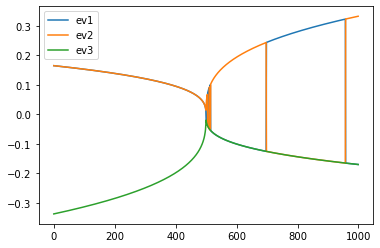

In [13]:
def plotevals(Rn=100, k=.35, r=.02, Rc=200, Ebar = .1, nu = .0036):
    nu = np.linspace(-1,1,1000)
    gamma = ((Rc+Rn)/(Rc*k))+1
    evals = [compevals(gamma, Rn, k, r, Rc, Ebar, n) for n in nu]
    
    ev1 = []
    ev2 = []
    ev3 = []
    
    for i in range(len(evals)):
        vals = list(evals[i].keys())
        ev1.append(re(vals[0]))
        ev2.append(re(vals[1]))
        ev3.append(re(vals[2]))
    n=0
    for i, j, k in zip(ev1, ev2, ev3):
        if i <= 0 and j <= 0 and k <= 0:
            print(n)
        else:
            n += 1
    print(n)       
    
    plt.plot(range(len(evals)), ev1, label='ev1')
    plt.plot(range(len(evals)), ev2, label='ev2')
    plt.plot(range(len(evals)), ev3, label='ev3')
    legend=plt.legend()
    
    plt.show()
plotevals()

In [15]:
##can dR/dtau > 0 when S(t) > 0? nullcline for R(t):
import math
R, S, g, k, n, r, c, b, E, v = symbols('R, S, g, k, n, r, c, b, E, v', real=True)
y = nonlinsolve([(-r/c)*R**2+r*R*(1-(n/c))+r*n-k*g*S],[R])
print(y)

FiniteSet((c/2 - n/2 - sqrt(r*(-4*S*c*g*k + c**2*r + 2*c*n*r + n**2*r))/(2*r),), (c/2 - n/2 + sqrt(r*(-4*S*c*g*k + c**2*r + 2*c*n*r + n**2*r))/(2*r),))


<h3>Stability analysis of genetic algorithm (Under Construction)</h3>
One question that we need to investigate is determining when $\frac{dE_S}{d\tau} > 0$ and $\frac{dE_G}{d\tau} > 0$. One thing that we find is that for high resources, $E_S$ may be bistable depending on $S(t)$:
$$
\frac{dE_S}{d\tau} = 0 = k\gamma p_sS(t)\frac{R(t)}{R(t)+R^*} - 1
$$
rearranging yields
$$
k\gamma p_s S(t) = \frac{R(t)+R^*}{R(t)}
$$
which for high resources evaluates to 
$$
k\gamma p_s S(t) \approx 1
$$
which yields the polynomial
$$
S^2(t)k\gamma - S(t) - G(t) = 0
$$
and solving via the quadratic formula, we find that $\frac{dE_S}{d\tau} > 0$ when
$$
S(t) > \frac{-1 + \sqrt{1+4k\gamma G(t)}}{2k\gamma} \text{ or } S(t) < \frac{-1 - \sqrt{1+4k\gamma G(t)}}{2k\gamma}
$$
However, the second solution would always be negative, so we should only really care about the first one.<br>
To find out when S(t) might be greater than this critical value, we can find the fixed points of $\frac{dS}{d\tau}$
$$
\frac{dS}{d\tau} = 0 = \nu_*S(t)(\frac{E_S}{\bar{E}}-1)
$$
which requires either $S(t) = 0$ or $E_S = \bar{E}$.
<br>
<br>
Looking back on the equilibrium analysis for $R$, we find that $dR/d\tau=0$ when 
$$
R(t) = \frac{-r^*(1 - \frac{R^*}{R_c}) \pm \sqrt{(r^*(1-\frac{R^*}{R_c}))^2 + 4(\frac{r^*}{R_c}(r^*R^*-\gamma\kappa))}}{2r^*/R_c}
$$
We also find that $dE_S/d\tau=0$ (without approximating for high resources) when
$$
R_{S^*}(t) = \frac{-R^*}{1-\gamma kp_sS(t)}
$$
And that $dE_G/d\tau=0$ when 
$$
R_{G^*}(t) = \frac{-\mu_lR^*}{\mu_l - \gamma\beta G(t)}
$$
Setting $R_{G^*}(t)=R_{S^*}(t)$ yields
$$
G(t) = \frac{\mu_lkp_s}{\beta}S(t)
$$
*This is where I am getting stuck. According to wolfram alpha G(t) evaluates to:*
$$
x = (2 k^3 s^6 u^3 + 3 k^2 s^5 u^2 + sqrt((2 k^3 s^6 u^3 + 3 k^2 s^5 u^2 - 9 k s^5 u - 3 k s^4 u + 27 k s^4 - 18 s^4 - 2 s^3)^2 + 4 (3 (s^3 - k s^3 u) - (s - k s^2 u)^2)^3) - 9 k s^5 u - 3 k s^4 u + 27 k s^4 - 18 s^4 - 2 s^3)^(1/3)/(3 2^(1/3)) - (2^(1/3) (3 (s^3 - k s^3 u) - (s - k s^2 u)^2))/(3 (2 k^3 s^6 u^3 + 3 k^2 s^5 u^2 + sqrt((2 k^3 s^6 u^3 + 3 k^2 s^5 u^2 - 9 k s^5 u - 3 k s^4 u + 27 k s^4 - 18 s^4 - 2 s^3)^2 + 4 (3 (s^3 - k s^3 u) - (s - k s^2 u)^2)^3) - 9 k s^5 u - 3 k s^4 u + 27 k s^4 - 18 s^4 - 2 s^3)^(1/3)) + 1/3 (k s^2 u - s)
$$
where $x=G(t), s=S(t), u = \mu_l$

In [4]:
import math
R, S, G, a, k, n, r, c, u = symbols('R, S, G, a, k, n, r, c, u', real=True)
y = nonlinsolve([(k*a*S*R/((S+G)*(R+n)))-1, (a*R/(R+n))*(((S**2)/G*(S+G))*(1-(k*S/(S+G))) + (G/(S+G))) - u, r*R*(1-(R/c)) - (a*R/(R+n))*(((S**2)/G*(S+G))*(1-(k*S/(S+G))) + (G/(S+G))) - (k*a*S*R/((S+G)*(R+n)))], [S,G,R])
print(y)

KeyboardInterrupt: 